In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
def plot_loss_curves(history,eval=None):
  loss, val_loss = history.history['loss'], history.history['val_loss']
  accuracy, val_accuracy = history.history['accuracy'], history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  if eval:
    eval_loss = [eval[0] for _ in epochs]
    eval_accuracy = [eval[1] for _ in epochs]

  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, label='Validation loss')
  if eval:
    plt.plot(epochs, eval_loss, label='Evaluation loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='Training accuracy')
  plt.plot(epochs, val_accuracy, label='Validation accuracy')
  if eval:
    plt.plot(epochs, eval_accuracy, label='Evaluation accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [ ]:
(train_ds, valid_ds, test_ds), info = tfds.load('mnist',
                                        split=['train[20%:]','train[0%:20%]', 'test'],
                                        as_supervised=True, with_info=True)

# CNN model

## Loading a Handwritten Digits dataset from TF datasets

In [ ]:
train_ds, valid_ds, test_ds = tfds.load('mnist',
                                        split=['train[20%:]','train[0%:20%]', 'test'],
                                        as_supervised=True)

In [ ]:
print("Train set size: ", len(train_ds))
print("Test set size: ", len(test_ds))
print("Valid set size: ", len(valid_ds))

Train set size:  48000
Test set size:  10000
Valid set size:  12000


In [ ]:
train_ds = train_ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds, valid_ds, test_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Visualize random training batch

In [ ]:
def view_random_batch(images, labels):
  fig, axes = plt.subplots(8,4,figsize=(10,20))
  axes = axes.flatten()
  for image, label, ax in zip(images, labels, axes):
    ax.imshow(image[:,:,0], cmap='gray')
    ax.set_title(label)
    ax.axis('off')

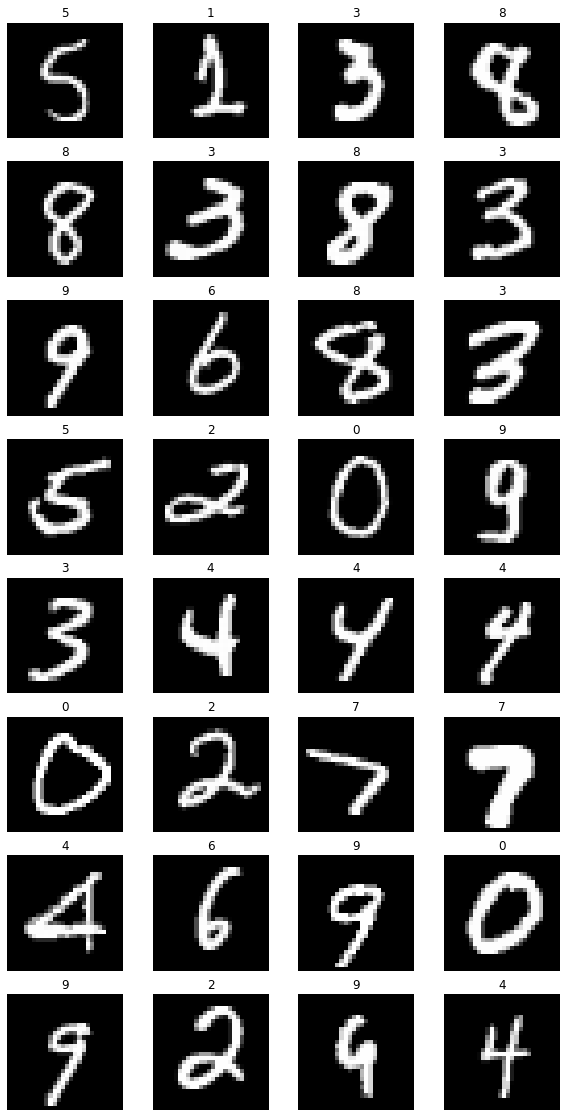

In [ ]:
for image, label in train_ds.take(1):
  view_random_batch(image.numpy(), label.numpy())

## Creating a regular CNN model for a baseline

In [ ]:
input = tf.keras.layers.Input((28,28,1))

rescaled = tf.keras.layers.Rescaling(1/255.)(input)

x = tf.keras.layers.Conv2D(32,3,activation='relu')(rescaled)
x = tf.keras.layers.Conv2D(64,3,activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Dropout(.25)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(.5)(x)
output = tf.keras.layers.Dense(10, activation='softmax')(x)

model_base = tf.keras.Model(inputs=input, outputs=output, name='mnist_baseline')

In [ ]:
model_base.summary()

Model: "mnist_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                    

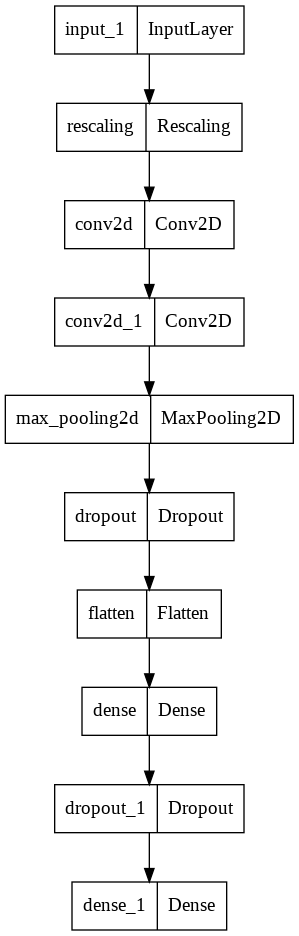

In [ ]:
tf.keras.utils.plot_model(model_base, 'baseline_model.png')

In [ ]:
model_base.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
history_base = model_base.fit(train_ds,
                              epochs=15,
                              steps_per_epoch=len(train_ds),
                              validation_data=valid_ds,
                              validation_steps=int(.15*len(valid_ds)),
                              callbacks=[early_stopping])

Epoch 1/15
1500/1500 [==============================] - 126s 84ms/step - loss: 0.3090 - accuracy: 0.9032 - val_loss: 0.0565 - val_accuracy: 0.9855
Epoch 2/15
1500/1500 [==============================] - 123s 82ms/step - loss: 0.1341 - accuracy: 0.9592 - val_loss: 0.0501 - val_accuracy: 0.9849
Epoch 3/15
1500/1500 [==============================] - 123s 82ms/step - loss: 0.1013 - accuracy: 0.9699 - val_loss: 0.0466 - val_accuracy: 0.9877
Epoch 4/15
1500/1500 [==============================] - 123s 82ms/step - loss: 0.0882 - accuracy: 0.9740 - val_loss: 0.0333 - val_accuracy: 0.9916
Epoch 5/15
1500/1500 [==============================] - 123s 82ms/step - loss: 0.0757 - accuracy: 0.9765 - val_loss: 0.0411 - val_accuracy: 0.9888
Epoch 6/15
1500/1500 [==============================] - 122s 81ms/step - loss: 0.0663 - accuracy: 0.9784 - val_loss: 0.0387 - val_accuracy: 0.9894
Epoch 7/15
1500/1500 [==============================] - 122s 81ms/step - loss: 0.0618 - accuracy: 0.9801 - val_loss: 0

In [ ]:
evaluation_base = model_base.evaluate(test_ds)
evaluation_base

313/313 [==============================] - 7s 21ms/step - loss: 0.0326 - accuracy: 0.9908


[0.03256892412900925, 0.9908000230789185]

In [ ]:
model_base.save('base_model.h5')

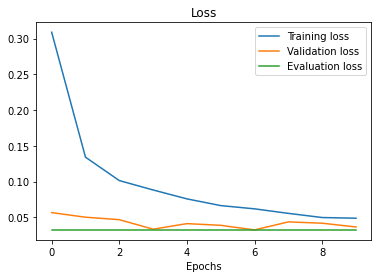

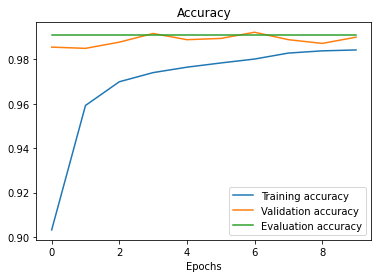

In [ ]:
plot_loss_curves(history_base, evaluation_base)

In [ ]:
base_json = {
    'history':history_base.history,
    'evaluation':{
        'loss':evaluation_base[0],
        'accuracy':evaluation_base[1]
    }
}

In [ ]:
import json

with open('base_data.json','w') as f:
  json.dump(base_json, f)

# Creating a siamese network

## Loading data

In [ ]:
train_ds, valid_ds, test_ds = tfds.load('mnist',
                                        split=['train[20%:]','train[0%:20%]', 'test'],
                                        as_supervised=True)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
print("Train set size: ", len(train_ds))
print("Test set size: ", len(test_ds))
print("Valid set size: ", len(valid_ds))

Train set size:  48000
Test set size:  10000
Valid set size:  12000


## Helper functions

Inspiration: https://deepnote.com/@svpino/Contrastive-Learning-7a0ec6e4-6a1d-43c7-9d30-aad8ad367334

The difference in data preparation:
1. We need to create a pairs of data, label them 1 if they match and 0 if they dont;
2. Create normalization, accuracy and loss function;

In [ ]:
def generate_pairs(dataset):
  '''
    Code taken from @svpino deepnote link:
      https://deepnote.com/@svpino/Contrastive-Learning-7a0ec6e4-6a1d-43c7-9d30-aad8ad367334
  '''
  x_pairs = []
  y_pairs = []

  # converting PrefetchDataset to python list
  images, labels = zip(*[(example.numpy(), label.numpy()) for example, label in dataset])

  for i in range(len(images)):
    label = labels[i]

    j = np.random.choice(np.where(labels==label)[0])
    x_pairs.append([images[i], images[j]])
    y_pairs.append([1])

    k = np.random.choice(np.where(labels!=label)[0])
    x_pairs.append([images[i], images[k]])
    y_pairs.append([0])

  #shuffling x_pairs and y_pairs
  indices = np.arange(len(x_pairs))
  np.random.shuffle(indices)

  return np.array(x_pairs)[indices], np.array(y_pairs)[indices]
  

In [ ]:
def norm(vectors):
  '''
    Code taken from @svpino deepnote link:
      https://deepnote.com/@svpino/Contrastive-Learning-7a0ec6e4-6a1d-43c7-9d30-aad8ad367334
  '''
  return tf.norm(vectors[0]-vectors[1], axis=1, keepdims=True)

def accuracy(y_true, y_pred):
  '''
    Code taken from @svpino deepnote link:
      https://deepnote.com/@svpino/Contrastive-Learning-7a0ec6e4-6a1d-43c7-9d30-aad8ad367334
  '''
  # The close y_pred is to 0, the shorter difference between images
  return tf.metrics.binary_accuracy(y_true, 1 - y_pred)

def contrastive_loss(y_true, y_pred):
  '''
    Code taken from @svpino deepnote link:
      https://deepnote.com/@svpino/Contrastive-Learning-7a0ec6e4-6a1d-43c7-9d30-aad8ad367334
  '''
  margin = 1
  y_true = tf.cast(y_true, y_pred.dtype)

  loss = y_true / 2 * tf.keras.backend.square(y_pred) + (1-y_true) / 2 \
        + tf.keras.backend.square(tf.keras.backend.maximum(0.0, margin - y_pred))

  return loss


## Data preparation

In [ ]:
x_train, y_train = generate_pairs(train_ds)
x_val, y_val = generate_pairs(valid_ds)
x_test, y_test = generate_pairs(test_ds)

In [ ]:
y_train.shape

(96000, 1)

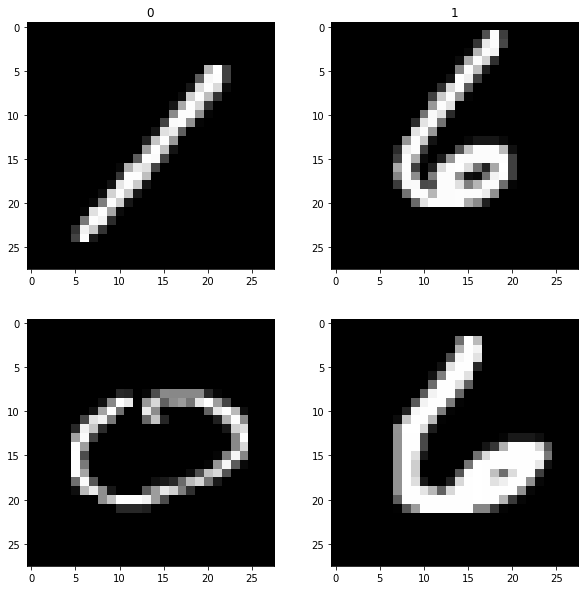

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
for idx,(a,b,c) in enumerate(zip(x_train[:2,0,...],x_train[:2,1,...],y_train[:2])):
    axes[0, idx].imshow(a[:,:,0], cmap='gray')
    axes[0, idx].set_title(c[0])
    axes[1, idx].imshow(b[:,:,0], cmap='gray')

In [ ]:
def prepare_dataset(examples, labels):
  dataset = tf.data.Dataset.from_tensor_slices(({'input1':examples[:,0], 'input2':examples[:,1]}, labels))

  return dataset.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds = prepare_dataset(x_train, y_train)
valid_ds = prepare_dataset(x_val,y_val)
test_ds = prepare_dataset(x_test,y_test)

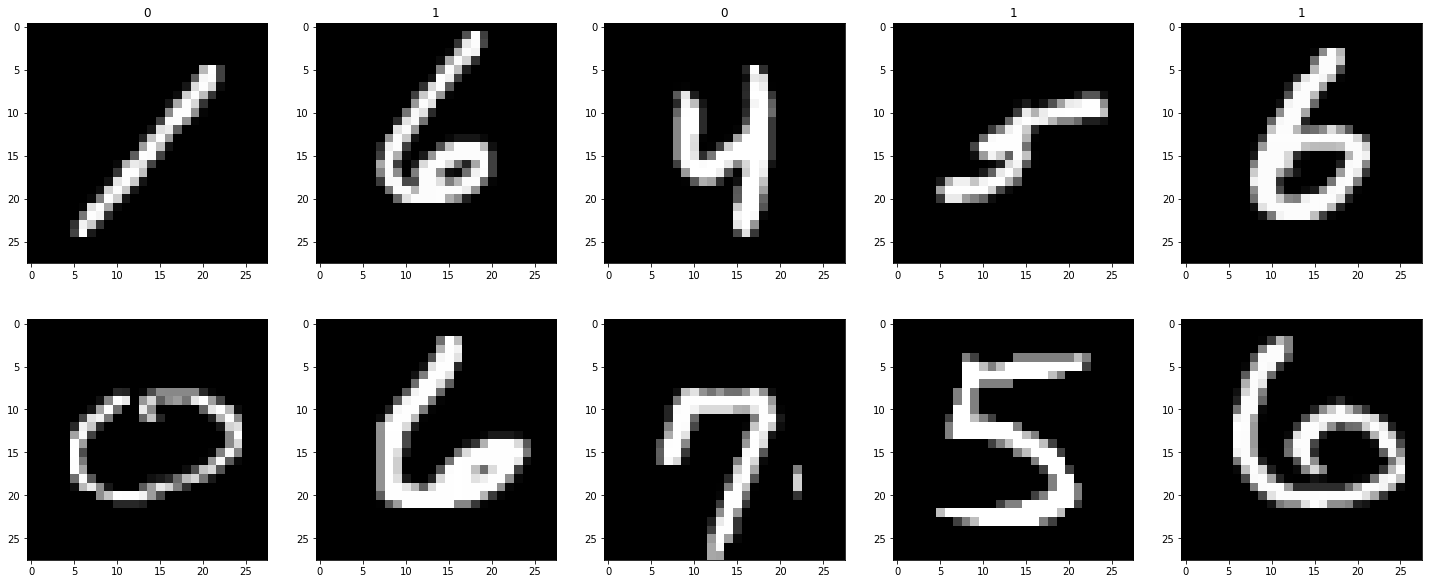

In [ ]:
for i,j in train_ds.take(1):
  l = 5
  img1 = i['input1'][:l]
  img2 = i['input2'][:l]
  label = j[:l]
  fig, axes = plt.subplots(2,l,figsize=(l*5,10))
  for idx,(a,b,c) in enumerate(zip(img1,img2,label)):
    axes[0, idx].imshow(a[:,:,0], cmap='gray')
    axes[0, idx].set_title(c.numpy()[0])
    axes[1, idx].imshow(b[:,:,0], cmap='gray')

## Creating model

In [ ]:
def siamese_twin():
  input = tf.keras.layers.Input((28,28,1))

  rescaled = tf.keras.layers.Rescaling(1/255.)(input)

  x = tf.keras.layers.Conv2D(128,2,activation='relu')(rescaled)
  x = tf.keras.layers.MaxPooling2D((2,2))(x)
  x = tf.keras.layers.Dropout(.4)(x)

  x = tf.keras.layers.Conv2D(128,2,activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D((2,2))(x)
  x = tf.keras.layers.Dropout(.4)(x)

  x = tf.keras.layers.Conv2D(64,2,activation='relu')(x)
  x = tf.keras.layers.MaxPooling2D((2,2))(x)
  x = tf.keras.layers.Dropout(.4)(x)

  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  output = tf.keras.layers.Dense(128, activation=None)(x)

  return tf.keras.Model(input, output)

def siamese_network():
  input1 = tf.keras.layers.Input((28,28,1), name='input1')
  input2 = tf.keras.layers.Input((28,28,1), name='input2')

  twin = siamese_twin()

  distance = tf.keras.layers.Lambda(norm)([
      twin(input1),
      twin(input2)
  ])

  return tf.keras.Model(inputs=[input1, input2], outputs=distance)

In [ ]:
model = siamese_network()
model.compile(
    loss=contrastive_loss,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[accuracy]
)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_4 (Functional)           (None, 128)          107456      ['input1[0][0]',                 
                                                                  'input2[0][0]']                 
                                                                                                  
 lambda_2 (Lambda)              (None, 1)            0           ['model_4[0][0]',          

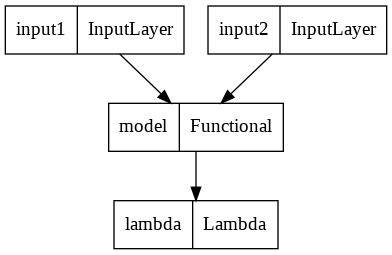

In [ ]:
tf.keras.utils.plot_model(model, 'siamese_model.png')

In [ ]:
history_siamese = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10
)

Epoch 1/10
3000/3000 [==============================] - 597s 199ms/step - loss: 0.4504 - accuracy: 0.5007 - val_loss: 0.6202 - val_accuracy: 0.8180
Epoch 2/10
3000/3000 [==============================] - 596s 199ms/step - loss: 0.4410 - accuracy: 0.5026 - val_loss: 0.5707 - val_accuracy: 0.8990
Epoch 3/10
3000/3000 [==============================] - 589s 196ms/step - loss: 0.4381 - accuracy: 0.5030 - val_loss: 0.5530 - val_accuracy: 0.9142
Epoch 4/10
3000/3000 [==============================] - 596s 199ms/step - loss: 0.4370 - accuracy: 0.5038 - val_loss: 0.5473 - val_accuracy: 0.9229
Epoch 5/10
3000/3000 [==============================] - 589s 196ms/step - loss: 0.4359 - accuracy: 0.5039 - val_loss: 0.5508 - val_accuracy: 0.9293
Epoch 6/10
3000/3000 [==============================] - 592s 197ms/step - loss: 0.4358 - accuracy: 0.5042 - val_loss: 0.5468 - val_accuracy: 0.9305
Epoch 7/10
3000/3000 [==============================] - 589s 196ms/step - loss: 0.4356 - accuracy: 0.5042 - val_

In [ ]:
model.evaluate(test_ds)

625/625 [==============================] - 30s 48ms/step - loss: 0.5351 - accuracy: 0.9341


[0.5350714921951294, 0.934149980545044]

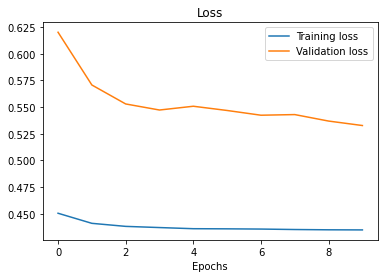

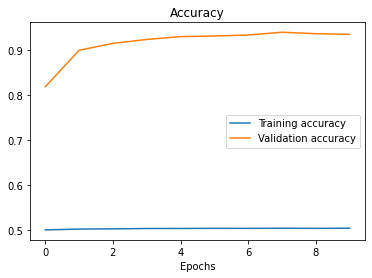

In [ ]:
plot_loss_curves(history_siamese)

In [ ]:
model.save('siamese_1.h5')

In [ ]:
model = tf.keras.models.load_model('siamese_1.h5', custom_objects={'contrastive_loss':contrastive_loss})

In [ ]:
x_test, y_test = generate_pairs(test_ds)

In [ ]:
# Get random  subset of 5 from test data
i1 = []
i2 = []
l = []

start_idx = np.random.randint(len(x_test)-5)

for i in range(start_idx,start_idx+5):
  #expand a batch dimension to images
  i1.append(tf.expand_dims(x_test[i,0],axis=0))
  i2.append(tf.expand_dims(x_test[i,1],axis=0))

  l.append(y_test[i])

#convert data to tf dataset
test_ds = tf.data.Dataset.from_tensor_slices(({'input1':np.array(i1), 'input2':np.array(i2)})).prefetch(tf.data.AUTOTUNE)

#making predictions on subset
predictions = model.predict(test_ds)

# thresholding values to make comparisons.
# if prediction is above .5, this means images are less similar
# else if prediction is below .5 this means images are more similar
th_pred = np.where(predictions >= 0.5,0,1)
th_pred= np.squeeze(th_pred)

In [ ]:
th_pred

array([0, 1, 1, 1, 1])

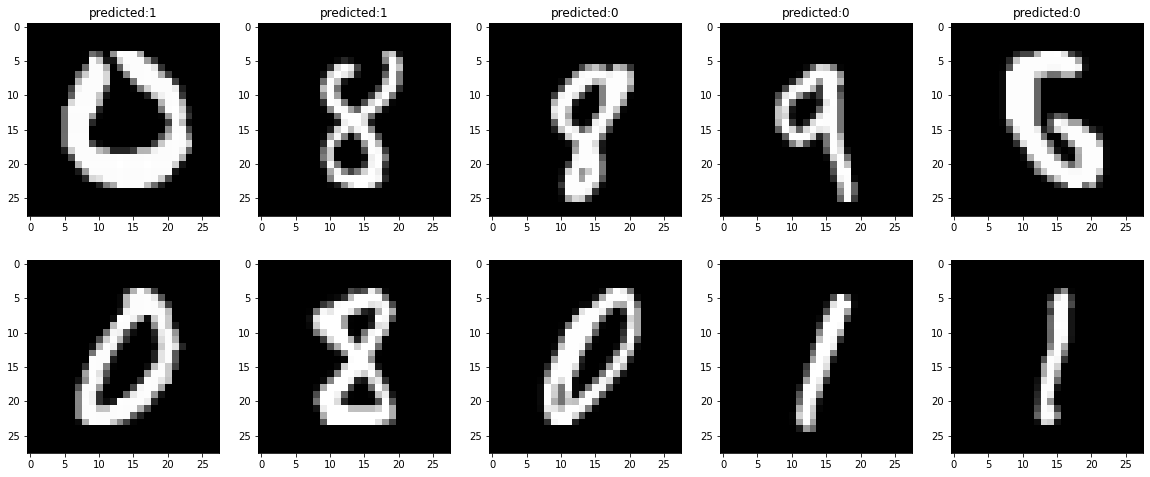

In [ ]:
#plotting prediction results
fig, axes = plt.subplots(2,5,figsize=(20,8))
for idx,i in enumerate(test_ds.take(5)):
  img1 = np.squeeze(i['input1'],axis=0)
  img2 = np.squeeze(i['input2'],axis=0)

  axes[0, idx].imshow(img1[:,:,0], cmap='gray')
  axes[0, idx].set_title(f'predicted:{th_pred[idx]}')
  axes[1, idx].imshow(img2[:,:,0], cmap='gray')